# Background

- Since I am struggling to get an adequate model for rotating the probe, I want to check that the measured value is constant when repeating the measurement at each step.

# Imports

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import pickle as pkl
from datetime import datetime
from datetime import timedelta
from pandas.api.types import is_numeric_dtype
from scipy.interpolate import interp1d
from scipy.spatial.transform import Rotation
import lmfit as lm
from copy import deepcopy
#from dateutil import parser
from plotly import graph_objects as go
from plotly.offline import plot
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

# local imports
from plotting import config_plots, datetime_plt, get_label
from load_slow import *
from Zaber_Magnet_Convert import *
# hallprobecalib package
from hallprobecalib.hpcplots import scatter3d, scatter2d, histo, spherical_scatter3d
from mu2e.mu2eplots import mu2e_plot3d
# V vs. B, T (2021 results)
from V_vs_B_T import V_forward, inv_B_v2, invert_row, calc_B_column

# from pandas.api.types import is_numeric_dtype
# from dateutil import parser

config_plots()
# plt.rcParams.update({"text.usetex": True})

In [3]:
ddir = '/home/ckampa/Dropbox/LogFiles/temp_rotate_07-06-22/'

In [8]:
# 8-11-22 10:42, probe ##, rotating in magnet, fine scan
# PGC @ 20 deg C
# 1 deg steps -10 -- +6 angle 0 (theta)
# 2 deg steps full 360 deg, centered on 0 deg angle 1 (phi)
######
plotdir = '/home/ckampa/data/hallprobecalib_extras/plots/hall_probe_rotate/2022-07-07_12:04/'
scanfile = ddir+'2022-08-11 104249.txt'
slowfile = ddir+'2022-07-18 153459slow.txt'

# Load & Process Data

In [46]:
# temperature
df_temp = load_data(slowfile)

In [47]:
df_temp

,Time,Magnet Current [A],Magnet Voltage [V],Coil 1,Coil 2,LCW in Coil1,LCW out Coil 1,LCW in Coil 2,LCW out Coil 2,Yoke (near pole),...,Return Magnet (NWC-R),Chiller Exhaust (NW),Supply Magnet (NWC-S),NaN (NWC-S),Supply PS (FNAL),NMR [T],NMR [FFT],seconds_delta,hours_delta,days_delta
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-07-18 15:35:00,7/18/2022 3:35:00 PM,128.038503,14.520857,20.172779,19.498810,7.294656,10.641733,10.777012,9.891079,24.216312,...,10.005183,31.155783,7.957991,18.461817,31.242691,0.734933,0.0,0.0,0.000000,0.000000
2022-07-18 15:35:36,7/18/2022 3:35:36 PM,128.038107,14.517358,20.126730,19.449253,7.614744,10.714738,10.928864,10.098615,24.206146,...,10.090763,30.256037,8.250588,18.460640,31.236366,0.734933,0.0,36.0,0.010000,0.000417
2022-07-18 15:40:37,7/18/2022 3:40:37 PM,128.037993,14.518373,20.142616,19.518778,7.428334,10.656361,10.775543,9.964303,24.158566,...,9.928845,30.788649,8.042071,18.483252,31.255045,0.734934,0.0,337.0,0.093611,0.003900
2022-07-18 15:45:37,7/18/2022 3:45:37 PM,128.038050,14.518932,20.131069,19.502581,7.302032,10.634292,10.769531,9.874829,24.110613,...,10.065604,30.895071,7.792184,18.491770,31.260956,0.734935,0.0,637.0,0.176944,0.007373
2022-07-18 15:50:37,7/18/2022 3:50:37 PM,128.038050,14.519807,20.140829,19.496239,7.643779,10.999976,11.081547,10.143119,24.069481,...,10.603743,31.996197,7.747221,18.460934,31.269251,0.734936,0.0,937.0,0.260278,0.010845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-11 10:45:44,8/11/2022 10:45:44 AM,128.037540,14.467873,18.058464,17.354229,6.740770,8.562215,8.598734,8.768024,16.457445,...,8.949029,30.449862,6.588402,18.392393,37.256134,0.735105,0.0,2056244.0,571.178889,23.799120
2022-08-11 10:50:44,8/11/2022 10:50:44 AM,128.037540,14.469202,18.065275,17.363981,6.524210,8.441722,8.615975,8.621886,16.461447,...,8.946935,30.782858,6.338153,18.515049,37.286907,0.735104,0.0,2056544.0,571.262222,23.802593
2022-08-11 10:55:43,8/11/2022 10:55:43 AM,128.037427,14.470253,18.069454,17.349716,6.590534,8.594252,8.730584,8.718352,16.453659,...,9.372453,31.079142,6.091188,18.475714,37.283413,0.735105,0.0,2056843.0,571.345278,23.806053


<AxesSubplot:xlabel='Datetime'>

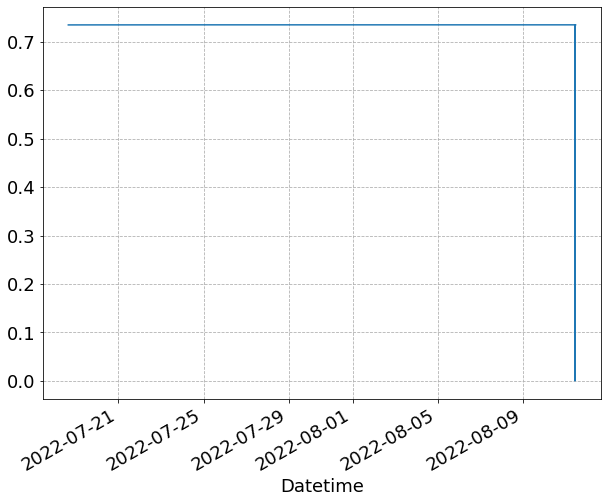

In [48]:
df_temp['NMR [T]'].plot()

In [49]:
len(df_temp)

6860

In [50]:
df_temp = df_temp.query('`NMR [T]` > 0.7').copy()

In [51]:
len(df_temp)

6859

<AxesSubplot:xlabel='Datetime'>

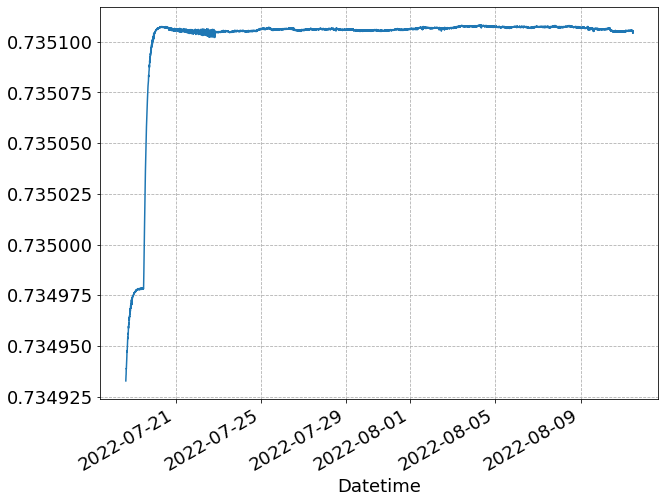

In [52]:
df_temp['NMR [T]'].plot()

In [53]:
df_temp['NMR [T]']

Datetime
2022-07-18 15:35:00    0.734933
2022-07-18 15:35:36    0.734933
2022-07-18 15:40:37    0.734934
2022-07-18 15:45:37    0.734935
2022-07-18 15:50:37    0.734936
                         ...   
2022-08-11 10:45:44    0.735105
2022-08-11 10:50:44    0.735104
2022-08-11 10:55:43    0.735105
2022-08-11 11:00:44    0.735104
2022-08-11 11:05:44    0.735104
Name: NMR [T], Length: 6859, dtype: float64

In [54]:
df = load_data(scanfile).iloc[1:]

In [55]:
df

,Time,Magnet Current [A],Magnet Voltage [V],NMR [T],NMR [FFT],2F0000000D5EC73A_Raw_X,2F0000000D5EC73A_Raw_Y,2F0000000D5EC73A_Raw_Z,2F0000000D5EC73A_Raw_T,2F0000000D5EC73A_Cal_X,...,2F0000000D5EC73A_Cal_T,SmarAct_Pattern_Angle_1,SmarAct_Pattern_Angle_2,SmarAct_Meas_Angle_1,SmarAct_Meas_Rotation_Angle_1,SmarAct_Meas_Angle_2,SmarAct_Meas_Rotation_Angle_2,seconds_delta,hours_delta,days_delta
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-08-11 10:43:23,8/11/2022 10:43:23 AM,128.037540,14.469108,0.0,0.0,-65060.0,-283449.0,-2016403.0,19344.0,0.726495,...,19.344,-8.0,-180.0,350.113947,-1.0,179.999975,-1.0,32.0,0.008889,0.000370
2022-08-11 10:43:30,8/11/2022 10:43:30 AM,128.037483,14.469455,0.0,0.0,-65132.0,-283469.0,-2016338.0,19348.0,0.726473,...,19.348,-8.0,-180.0,350.113937,-1.0,179.999998,-1.0,39.0,0.010833,0.000451
2022-08-11 10:43:37,8/11/2022 10:43:37 AM,128.037427,14.469785,0.0,0.0,-65110.0,-283524.0,-2016323.0,19348.0,0.726468,...,19.348,-8.0,-180.0,350.113896,-1.0,179.999994,-1.0,46.0,0.012778,0.000532
2022-08-11 10:43:45,8/11/2022 10:43:45 AM,128.037483,14.470080,0.0,0.0,-65096.0,-283496.0,-2016396.0,19347.0,0.726494,...,19.347,-8.0,-180.0,350.113918,-1.0,180.000002,-1.0,54.0,0.015000,0.000625
2022-08-11 10:43:52,8/11/2022 10:43:52 AM,128.037540,14.470307,0.0,0.0,-65115.0,-283524.0,-2016517.0,19348.0,0.726537,...,19.348,-8.0,-180.0,350.113888,-1.0,180.000003,-1.0,61.0,0.016944,0.000706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-11 11:09:31,8/11/2022 11:09:31 AM,128.037257,14.466705,0.0,0.0,-173227.0,-215142.0,-2018343.0,19281.0,0.726517,...,19.281,-8.0,-154.0,350.113888,-1.0,205.999991,-1.0,1600.0,0.444444,0.018519
2022-08-11 11:09:39,8/11/2022 11:09:39 AM,128.037313,14.466777,0.0,0.0,-173201.0,-215111.0,-2018358.0,19282.0,0.726522,...,19.282,-8.0,-154.0,350.113902,-1.0,205.999999,-1.0,1608.0,0.446667,0.018611
2022-08-11 11:09:46,8/11/2022 11:09:46 AM,128.037370,14.466912,0.0,0.0,-173114.0,-215195.0,-2018399.0,19278.0,0.726536,...,19.278,-8.0,-154.0,350.113927,-1.0,205.999999,-1.0,1615.0,0.448611,0.018692


<AxesSubplot:xlabel='Datetime'>

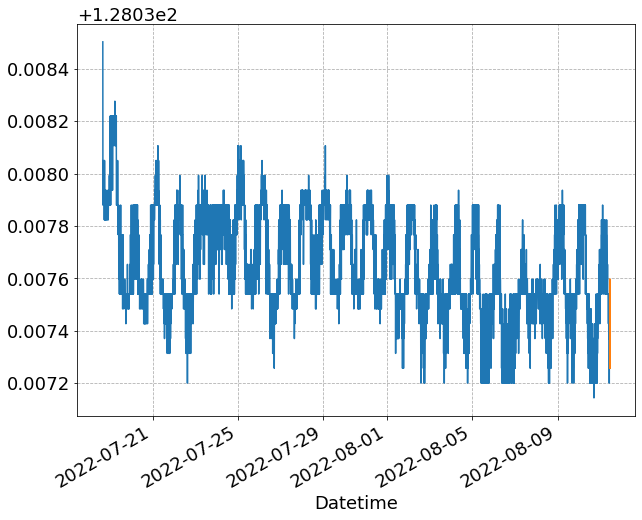

In [56]:
df_temp['Magnet Current [A]'].plot()
df['Magnet Current [A]'].plot()

In [57]:
df.columns

Index(['Time', 'Magnet Current [A]', 'Magnet Voltage [V]', 'NMR [T]',
       'NMR [FFT]', '2F0000000D5EC73A_Raw_X', '2F0000000D5EC73A_Raw_Y',
       '2F0000000D5EC73A_Raw_Z', '2F0000000D5EC73A_Raw_T',
       '2F0000000D5EC73A_Cal_X', '2F0000000D5EC73A_Cal_Y',
       '2F0000000D5EC73A_Cal_Z', '2F0000000D5EC73A_Cal_T',
       'SmarAct_Pattern_Angle_1', 'SmarAct_Pattern_Angle_2',
       'SmarAct_Meas_Angle_1', 'SmarAct_Meas_Rotation_Angle_1',
       'SmarAct_Meas_Angle_2', 'SmarAct_Meas_Rotation_Angle_2',
       'seconds_delta', 'hours_delta', 'days_delta'],
      dtype='object')

In [58]:
def get_probe_IDs(df):
    probes = [c[:-6] for c in df.columns if "Raw_X" in c]
    return sorted(probes)

In [59]:
probes = get_probe_IDs(df)
probe = probes[0]

In [60]:
probes, probe

(['2F0000000D5EC73A'], '2F0000000D5EC73A')

In [61]:
# Hall probe calculations
for p in probes:
    for t in ['Raw', 'Cal']:
        df[f'{p}_{t}_Bmag'] = (df[f'{p}_{t}_X']**2 + df[f'{p}_{t}_Y']**2 + df[f'{p}_{t}_Z']**2)**(1/2)
        df[f'{p}_{t}_Theta'] = np.arccos(df[f'{p}_{t}_Z']/df[f'{p}_{t}_Bmag'])
        df[f'{p}_{t}_Phi'] = np.arctan2(df[f'{p}_{t}_Y'],df[f'{p}_{t}_X'])
# again using theta redefining Cal components
for p in probes:
    for t in ['Cal']:
        df[f'{p}_{t}_Theta2'] = np.arccos(df[f'{p}_{t}_X']/df[f'{p}_{t}_Bmag'])
        df[f'{p}_{t}_Phi2'] = np.arctan2(df[f'{p}_{t}_Z'],df[f'{p}_{t}_Y'])

In [62]:
df['Magnet Resistance [Ohm]'] = df['Magnet Voltage [V]'] / df['Magnet Current [A]']
df['Coil Resistance [Ohm]'] = 2*df['Magnet Resistance [Ohm]']
df['Magnet Power [W]'] = df['Magnet Voltage [V]'] * df['Magnet Current [A]']

In [63]:
df[['Magnet Power [W]', 'Coil Resistance [Ohm]']]

,Magnet Power [W],Coil Resistance [Ohm]
Datetime,,
2022-08-11 10:43:23,1852.589037,0.226014
2022-08-11 10:43:30,1852.632603,0.226019
2022-08-11 10:43:37,1852.674036,0.226024
2022-08-11 10:43:45,1852.712627,0.226029
2022-08-11 10:43:52,1852.742469,0.226032
...,...,...
2022-08-11 11:09:31,1852.277221,0.225976
2022-08-11 11:09:39,1852.287217,0.225978
2022-08-11 11:09:46,1852.305322,0.225980


<AxesSubplot:xlabel='Datetime'>

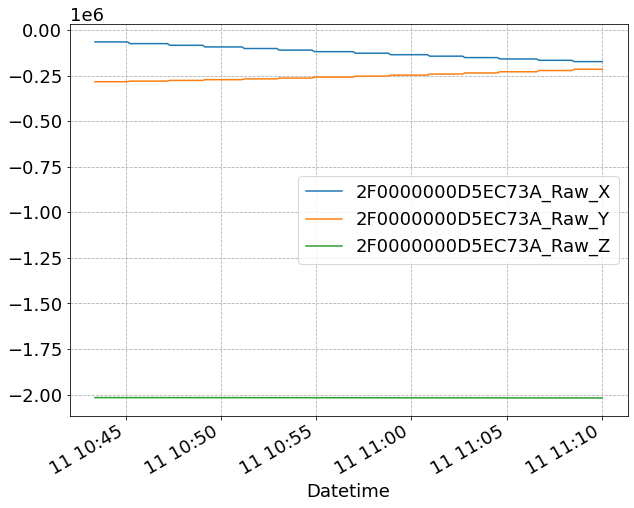

In [64]:
df[[f'{probe}_Raw_{i}' for i in ['X', 'Y', 'Z']]].plot()

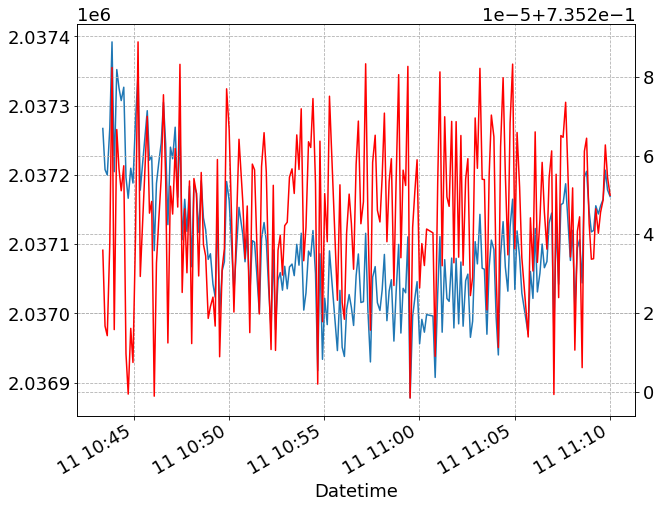

In [65]:
ax = df[f'{probe}_Raw_Bmag'].plot()
ax2 = ax.twinx()
ax2.plot(df.index, df[f'{probe}_Cal_Bmag'], 'r')

<AxesSubplot:xlabel='Datetime'>

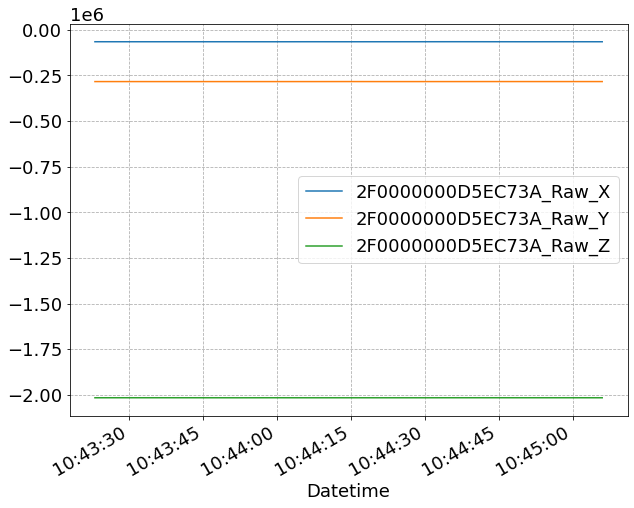

In [66]:
df[[f'{probe}_Raw_{i}' for i in ['X', 'Y', 'Z']]].iloc[:15].plot()

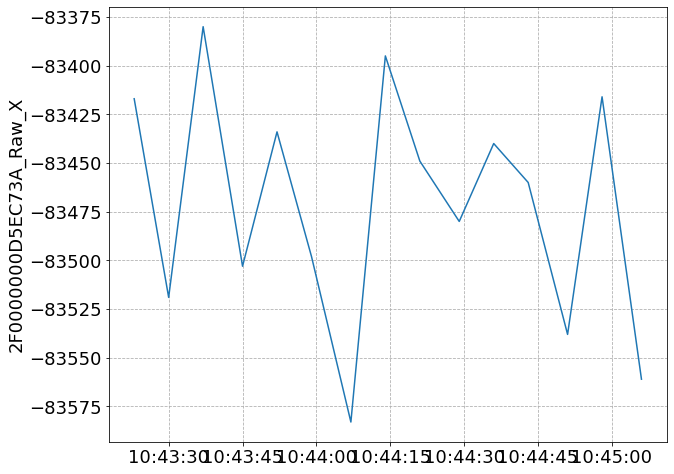

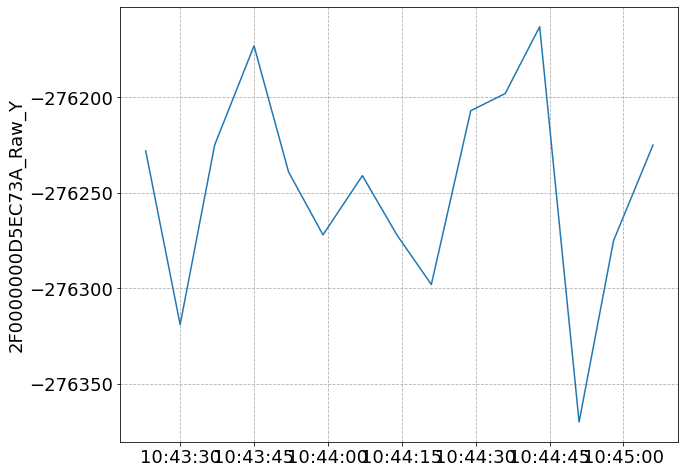

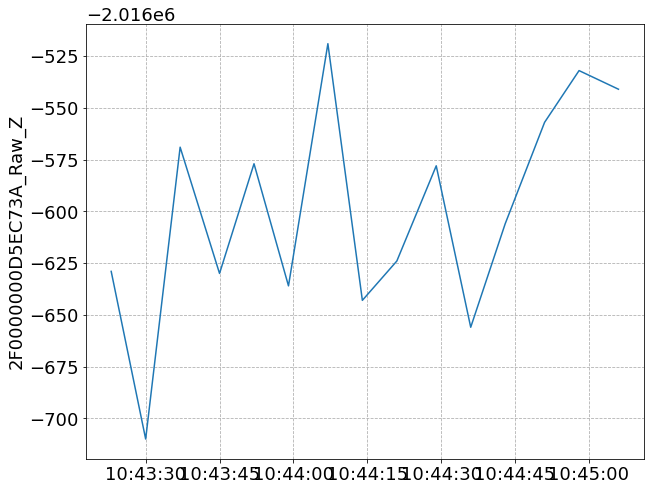

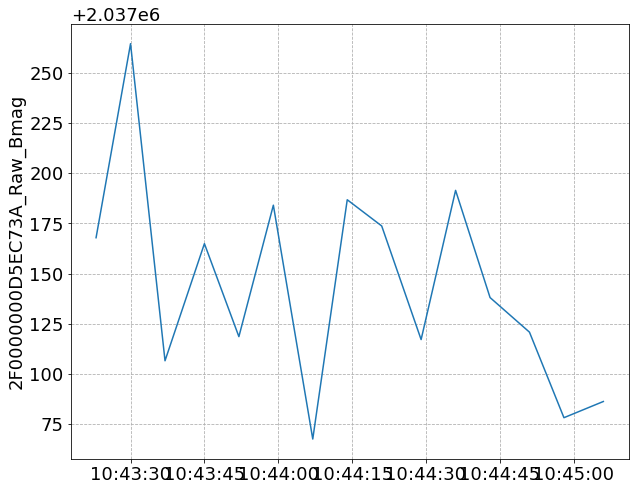

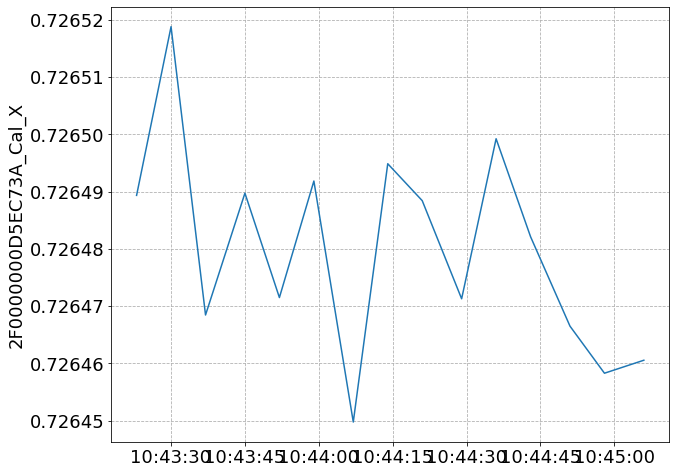

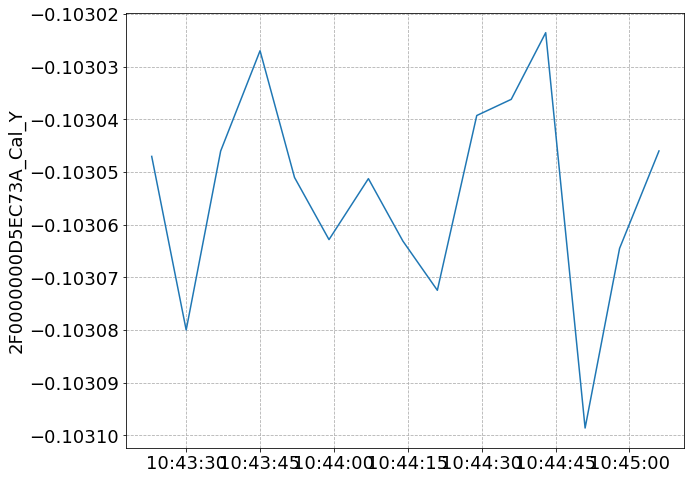

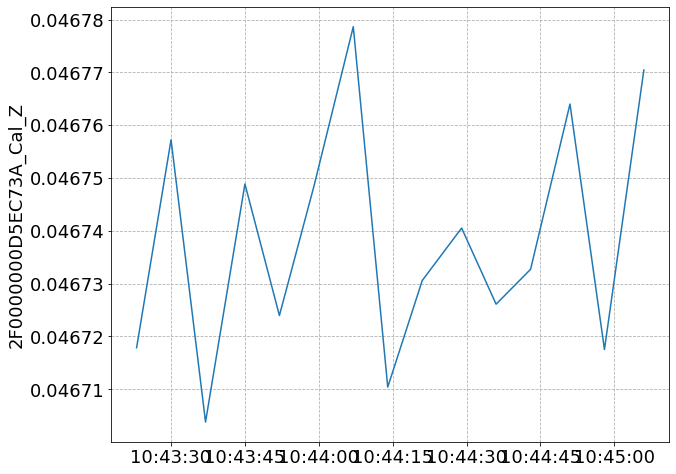

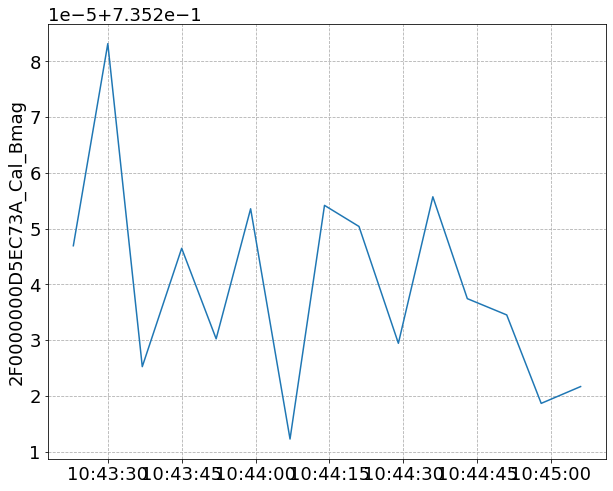

In [71]:
N = 2
for cal in ['Raw', 'Cal']:
    for i in ['X', 'Y', 'Z', 'Bmag']:
        fig, ax = plt.subplots()
        ax.plot(df.iloc[:15].index, df[f'{probe}_{cal}_{i}'].iloc[N*15:(N+1)*15])
        ax.set_ylabel(f'{probe}_{cal}_{i}')